In [19]:
%matplotlib inline
from spectral_cube import SpectralCube
from signal_id.utils import get_pixel_scales
import matplotlib.pyplot as p
import seaborn as sns
sns.set_context('poster')
import numpy as np
import os

import skimage.morphology as mo
import scipy.ndimage as nd

In [20]:
execfile("basics/bubble_segment.py")

In [21]:
data_path = "/media/eric/Data_3/VLA/IC1613/"

cube = SpectralCube.read(os.path.join(data_path, "IC1613_NA_ICL001.fits"))

# Remove empty channels
cube = cube[38:65, 500:1500, 500:1500]
print(cube.shape)

(27, 1000, 1000)


Make a 2D array with one hole in it (to start). Use the scaling and whatnot from IC1613

In [22]:
test_center_hole = np.ones_like(cube[0, :, :].value).astype("int16") * 255
xx, yy = np.mgrid[-500:500, -500:500]
test_center_hole[xx**2+yy**2<100] = 128

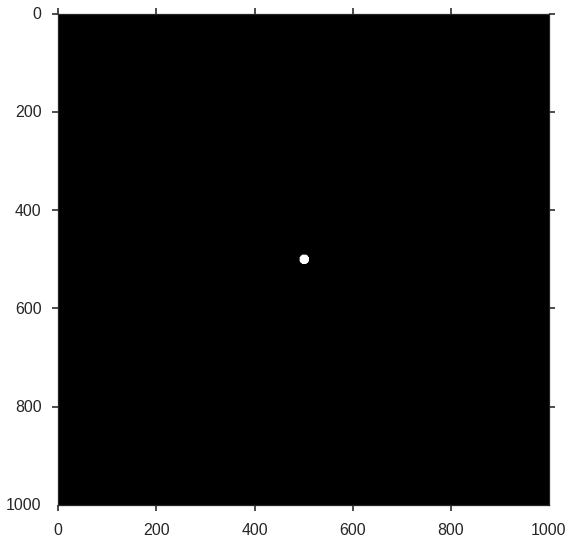

In [23]:
p.imshow(test_center_hole)

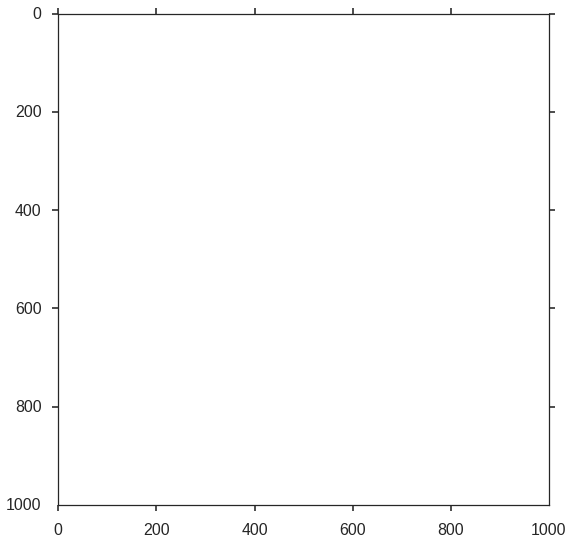

In [24]:
bubble_test = find_bubbles(test_center_hole, 2, cube.beam, cube.wcs)
p.imshow(bubble_test)

Overlapping holes of the same size

In [25]:
test_center_2hole = np.ones_like(cube[0, :, :].value).astype("int16") * 255
xx, yy = np.mgrid[-500:500, -500:500]
test_center_2hole[xx**2+yy**2<100] = 128
test_center_2hole[(xx-5)**2+(yy-5)**2<100] = 128

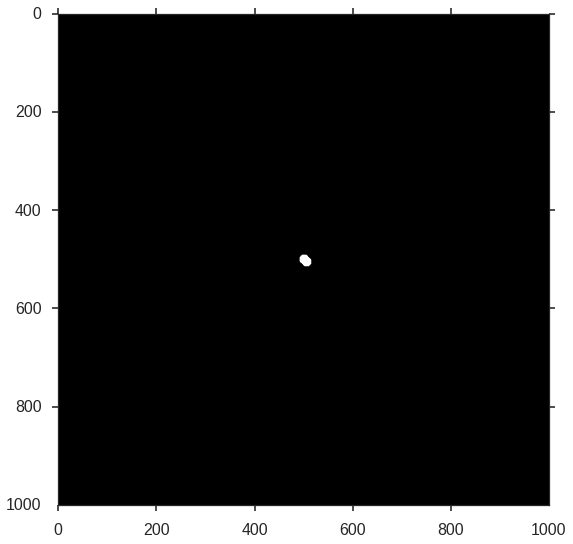

In [26]:
p.imshow(test_center_2hole)

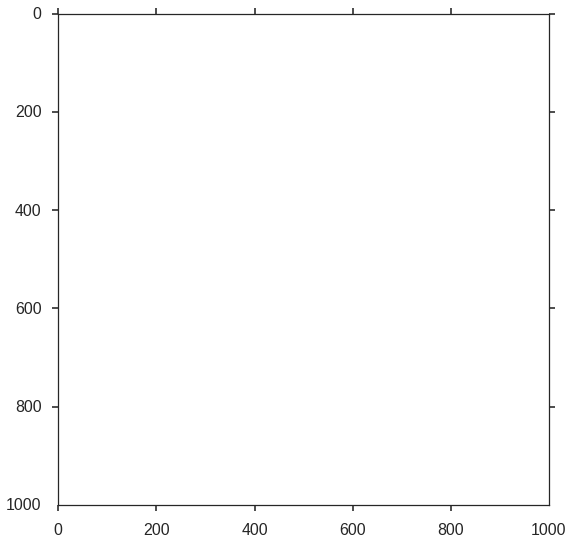

In [27]:
bubble_test_2 = find_bubbles(test_center_2hole, 2, cube.beam, cube.wcs)
p.imshow(bubble_test_2)

Yup. It works. Now let's randomly place them.

In [28]:
from astropy.modeling.models import Gaussian2D
from astropy.nddata.utils import add_array 

def add_holes(array, nholes=100, rad_max=30, rad_min=10):
    ylim, xlim = array.shape
    
    yy, xx = np.mgrid[-ylim/2:ylim/2, -xlim/2:xlim/2]
    
    
    xcenters = np.random.random_integers(-(xlim/2-rad_max), high=xlim/2-rad_max, size=nholes)
    ycenters = np.random.random_integers(-(ylim/2-rad_max), high=ylim/2-rad_max, size=nholes)
    radii = np.random.random_integers(rad_min, rad_max, size=nholes)
    
    for x, y, radius in zip(xcenters, ycenters, radii):
        array[(xx-x)**2+(yy-y)**2<radius**2] = np.random.random_integers(0, 230)
        
    return array

def add_gaussian_holes(array, nholes=100, rad_max=30, rad_min=10):
    ylim, xlim = array.shape
    
    yy, xx = np.mgrid[-ylim/2:ylim/2, -xlim/2:xlim/2]
    
    xcenters = np.random.random_integers(-(xlim/2-rad_max), high=xlim/2-rad_max, size=nholes)
    ycenters = np.random.random_integers(-(ylim/2-rad_max), high=ylim/2-rad_max, size=nholes)
    radii = np.random.random_integers(rad_min, rad_max, size=nholes)
    
    for x, y, radius in zip(xcenters, ycenters, radii):
        amp = np.random.uniform(0.5, 0.75)

        gauss = Gaussian2D.evaluate(yy, xx,
                                    amp, x, y, radius, radius, 0.0)

        array -= gauss
    
    return array

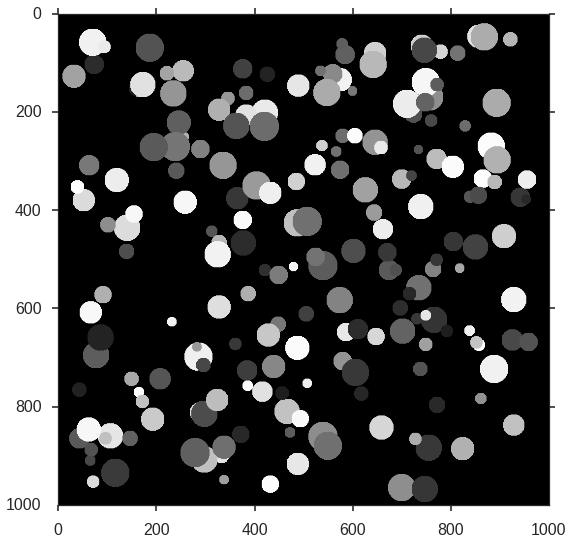

In [29]:
test_rand_holes = add_holes(np.ones_like(cube[0, :, :].value).astype("int16") * 255, nholes=200)
p.imshow(test_rand_holes)

In [30]:
def simple_bubble_find(array, radius, radius_small):
    
    struct = mo.disk(radius)
    struct_small = mo.disk(radius_small)

    # Black tophat
    bth = nd.black_tophat(array, structure=struct)

    # Adaptive threshold
    adapt = \
        threshold_adaptive(bth,
                           radius,
                           param=radius/2)

    # Open/close to clean things up
    opened = nd.binary_opening(adapt, structure=struct_small)
    closed = nd.binary_closing(opened, structure=struct_small)

    # Remove elements smaller than the original beam.
    beam_pixels = struct_small.sum()
    cleaned = mo.remove_small_objects(closed, min_size=beam_pixels,
                                      connectivity=2)
    
    return cleaned

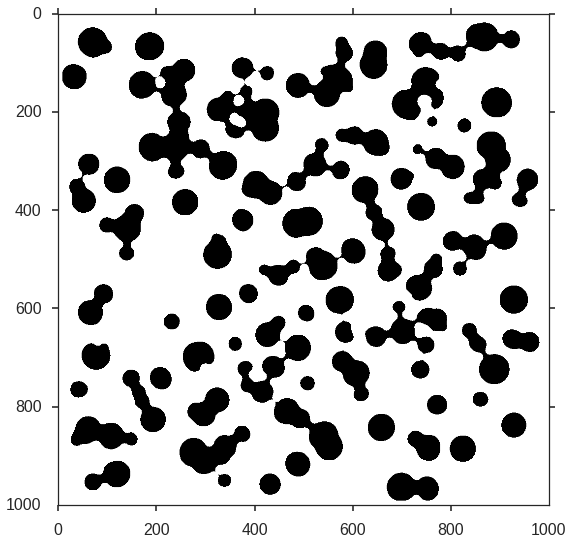

In [31]:
bubble_test_3 = simple_bubble_find(nd.gaussian_filter(test_rand_holes, 5), 50, 9)
p.imshow(bubble_test_3)

/home/eric/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


<matplotlib.contour.QuadContourSet instance at 0x7f4f1ae69440>

/home/eric/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


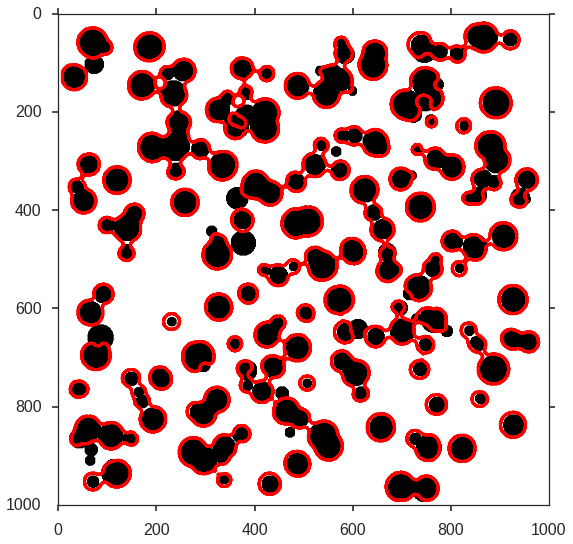

In [32]:
p.imshow(test_rand_holes<255)
p.contour(bubble_test_3, colors='r')

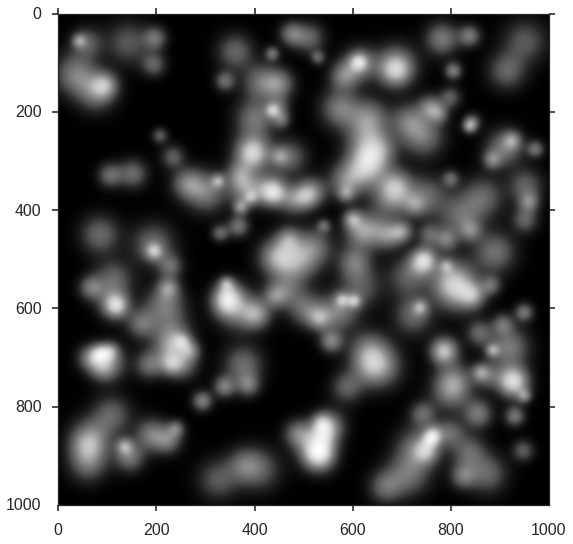

In [33]:
test_gauss_holes = add_gaussian_holes(np.ones((1000, 1000)), nholes=200)

p.imshow(test_gauss_holes)

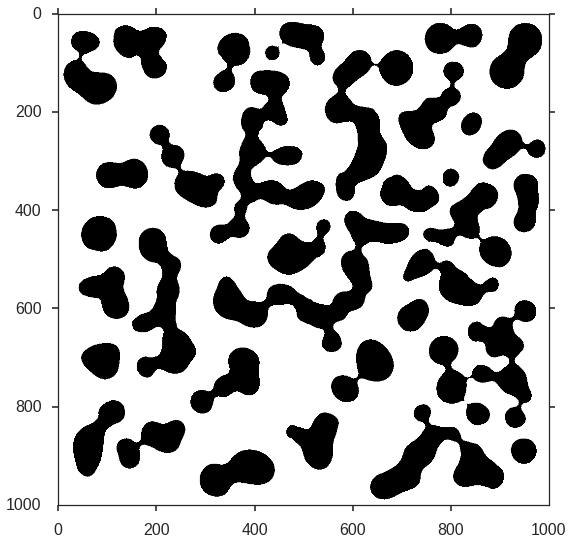

In [34]:
bubble_test_4 = simple_bubble_find(test_gauss_holes, 50, 9)
p.imshow(bubble_test_4)

<matplotlib.contour.QuadContourSet instance at 0x7f4f18220518>

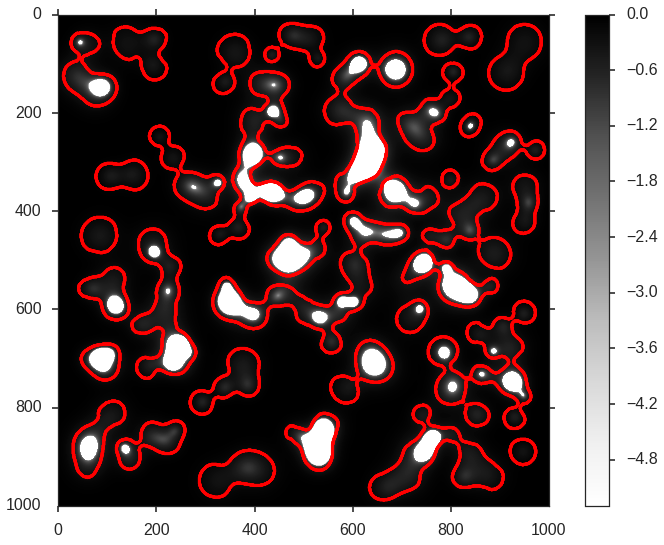

In [35]:
p.imshow(np.log10(test_gauss_holes))
p.colorbar()
p.contour(bubble_test_4, colors='r')

In [36]:
nd.label(bubble_test_4, np.ones((3,3)))[1]

36

<matplotlib.contour.QuadContourSet instance at 0x7f4f18029cf8>

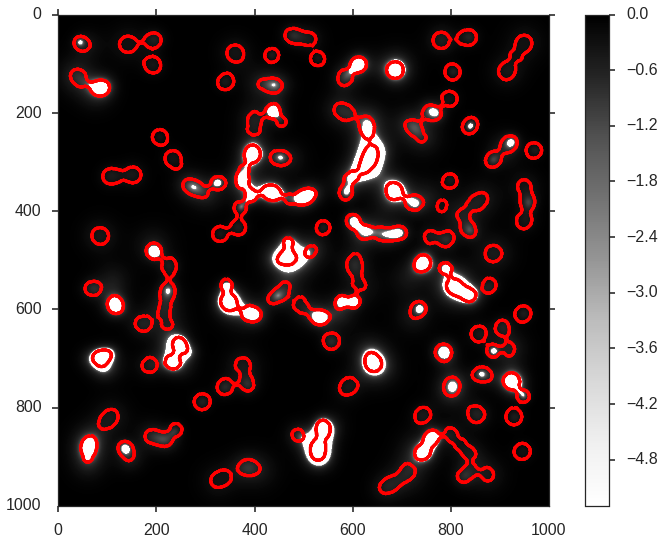

In [37]:
bubble_test_4_2 = simple_bubble_find(test_gauss_holes, 20, 9)

p.imshow(np.log10(test_gauss_holes))
p.colorbar()
p.contour(bubble_test_4_2, colors='r')

<matplotlib.contour.QuadContourSet instance at 0x7f4f136f8d88>

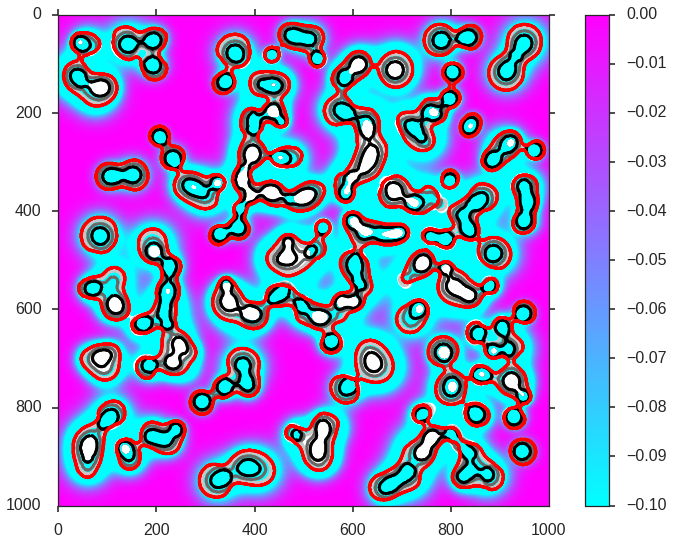

In [38]:
bubble_test_4_3 = simple_bubble_find(test_gauss_holes, 10, 9).astype(int) + \
    simple_bubble_find(test_gauss_holes, 20, 9).astype(int) + \
    simple_bubble_find(test_gauss_holes, 30, 9).astype(int) + \
    simple_bubble_find(test_gauss_holes, 40, 9).astype(int) + \
    simple_bubble_find(test_gauss_holes, 50, 9).astype(int)

p.imshow(np.log10(test_gauss_holes), cmap='cool', vmin=-0.1)
p.colorbar()
p.contour(bubble_test_4_3)
p.contour(bubble_test_4, colors='r')

Checks out! Now with noise...

Add the minimum as everything here is "signal".

In [39]:
test_gauss_holes += np.abs(test_gauss_holes.min())

In [40]:
from skimage.util import random_noise

<matplotlib.colorbar.Colorbar instance at 0x7f4f1351bea8>

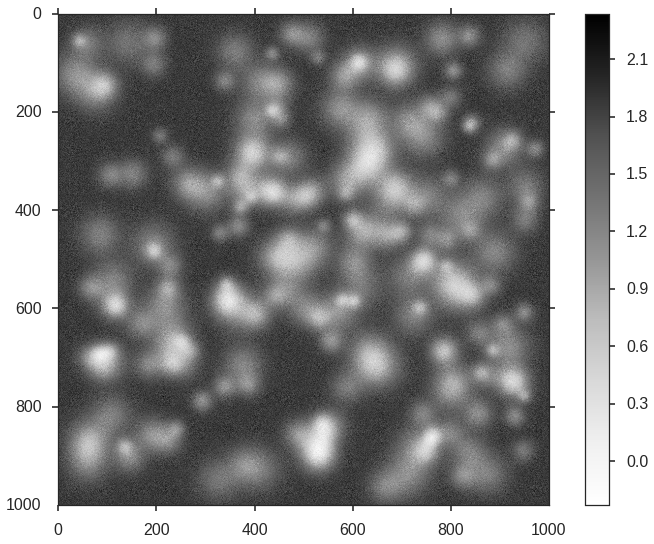

In [41]:
test_noisy_gauss_holes = random_noise(test_gauss_holes, mode='gaussian', var=0.01, seed=500, clip=False)

p.imshow(test_noisy_gauss_holes)
p.colorbar()

In [42]:
bubble_test_4_4 = simple_bubble_find(test_noisy_gauss_holes, 10, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 20, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 30, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 40, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 50, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 75, 9).astype(int) + \
    simple_bubble_find(test_noisy_gauss_holes, 100, 9).astype(int)

<matplotlib.contour.QuadContourSet instance at 0x7f4f13440e60>

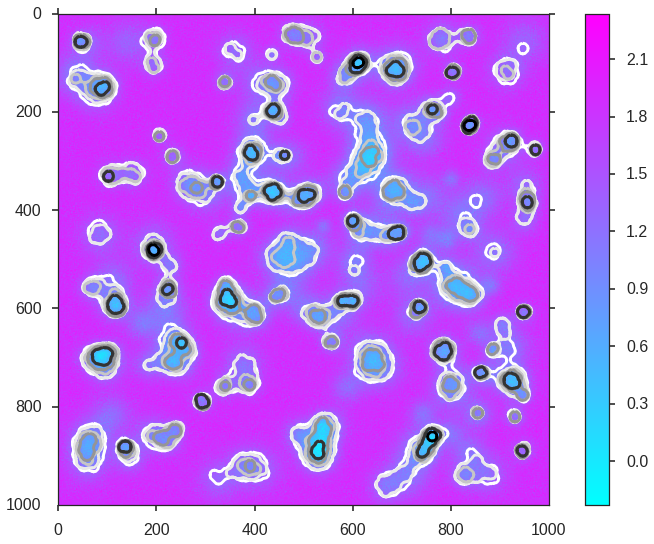

In [43]:
p.imshow(test_noisy_gauss_holes, cmap='cool')
p.colorbar()
p.contour(bubble_test_4_4)

Now what do we get in the pure noise case??

<matplotlib.colorbar.Colorbar instance at 0x7f4f132000e0>

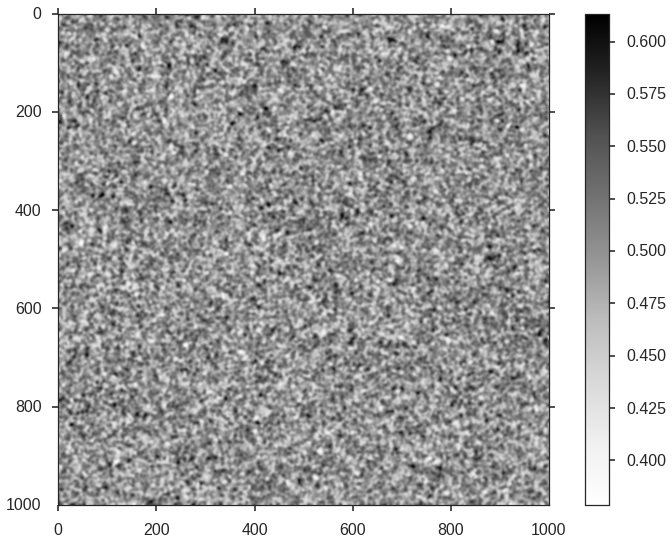

In [44]:
all_noise = nd.gaussian_filter(np.random.random((1000, 1000)), 3)

p.imshow(all_noise)
p.colorbar()

In [45]:
bubble_test_5 = simple_bubble_find(all_noise, 10, 3).astype(int) + simple_bubble_find(all_noise, 5, 3).astype(int) + \
    simple_bubble_find(all_noise, 20, 3).astype(int) + \
    simple_bubble_find(all_noise, 30, 3).astype(int) + \
    simple_bubble_find(all_noise, 40, 3).astype(int) + \
    simple_bubble_find(all_noise, 50, 3).astype(int) + \
    simple_bubble_find(all_noise, 75, 3).astype(int) + \
    simple_bubble_find(all_noise, 100, 3).astype(int)

<matplotlib.contour.QuadContourSet instance at 0x7f4f12fd1cb0>

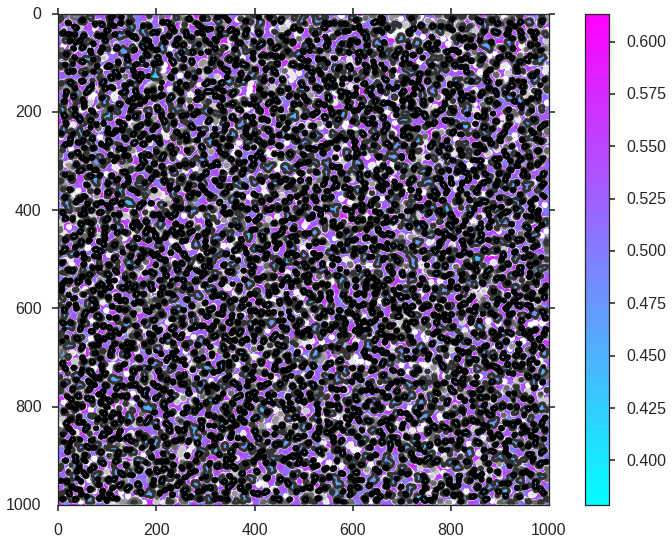

In [46]:
p.imshow(all_noise, cmap='cool')
p.colorbar()
p.contour(bubble_test_5)

<matplotlib.colorbar.Colorbar instance at 0x7f4f12d1abd8>

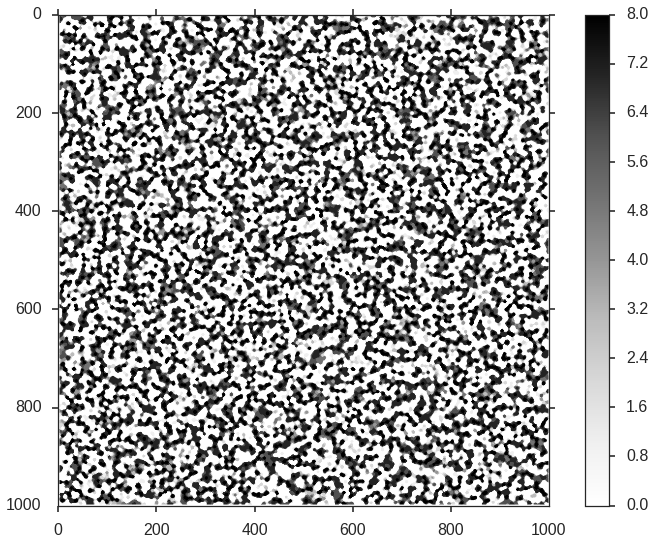

In [47]:
p.imshow(bubble_test_5)
p.colorbar()

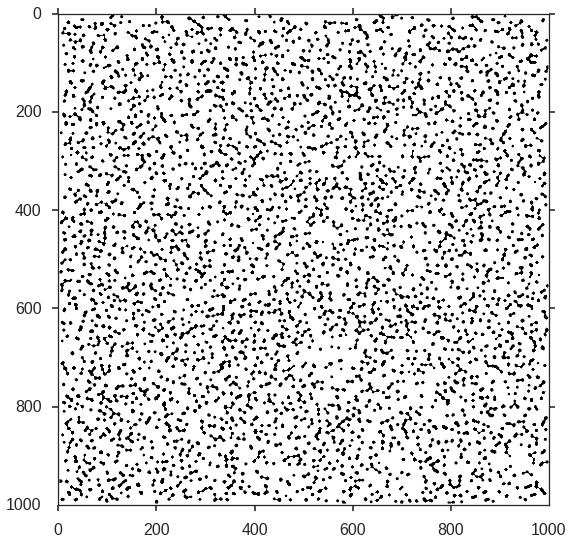

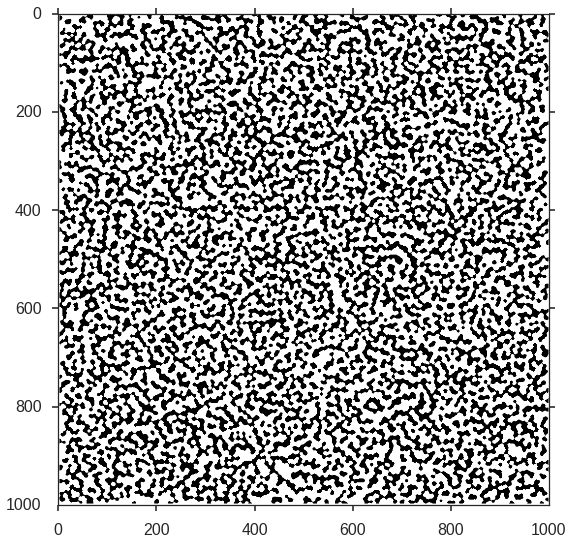

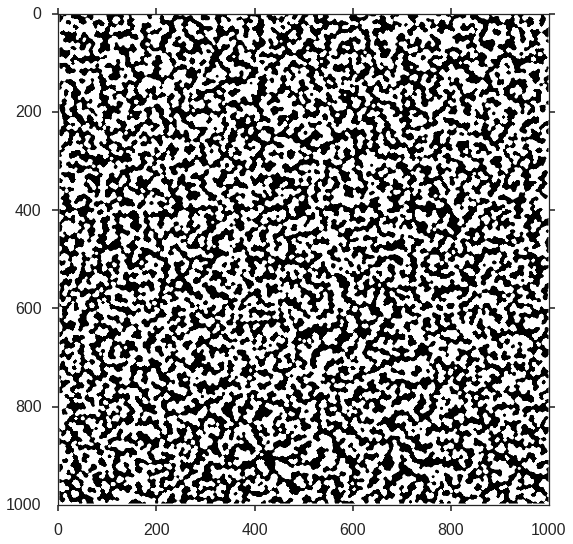

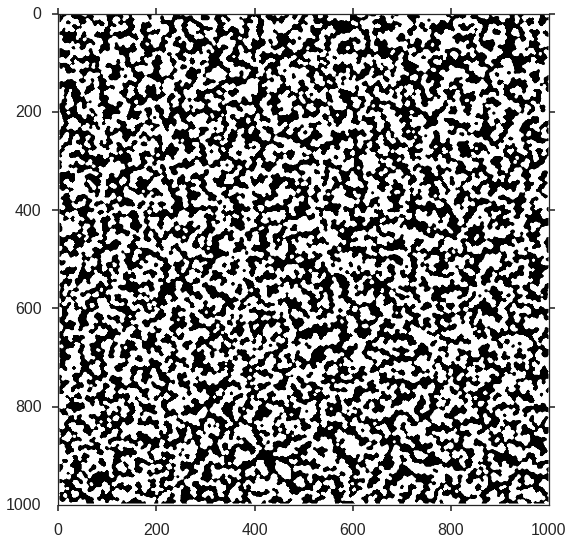

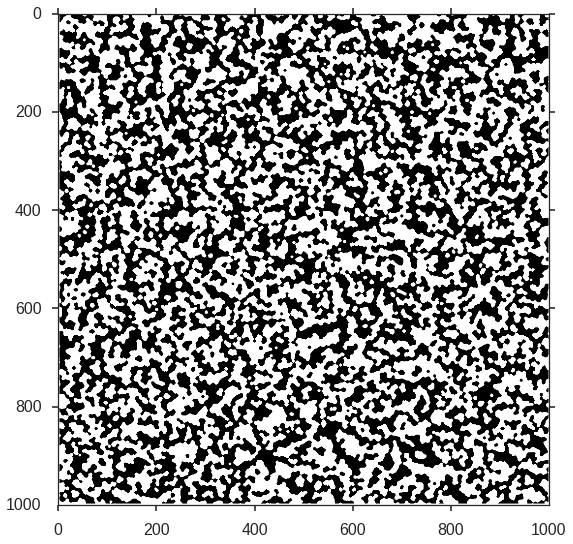

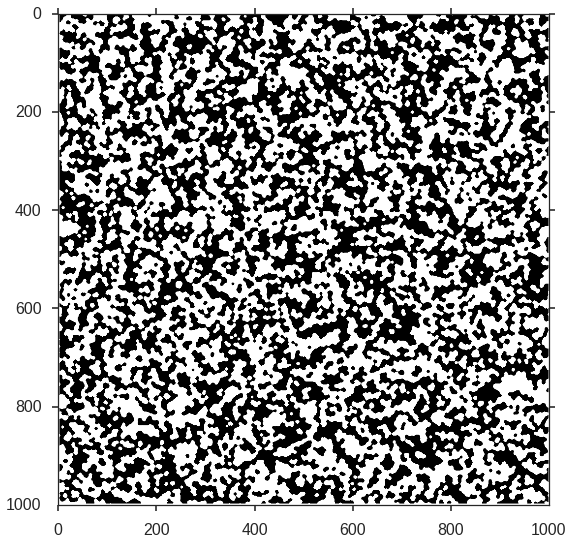

In [48]:
noise_1_output = []
for i in [5, 10, 20, 30, 50, 100]:
    result = simple_bubble_find(all_noise, i, 3).astype(int)
    noise_1_output.append(result)
    p.imshow(result)
    p.show()

So basically, smoothing by a perceived beam is what leads to the spurious features. Pure noise returns no spurious features.

So how much of this can we get rid of by comparing to and "adjacent" noise channel.

<matplotlib.colorbar.Colorbar instance at 0x7f4f1274d320>

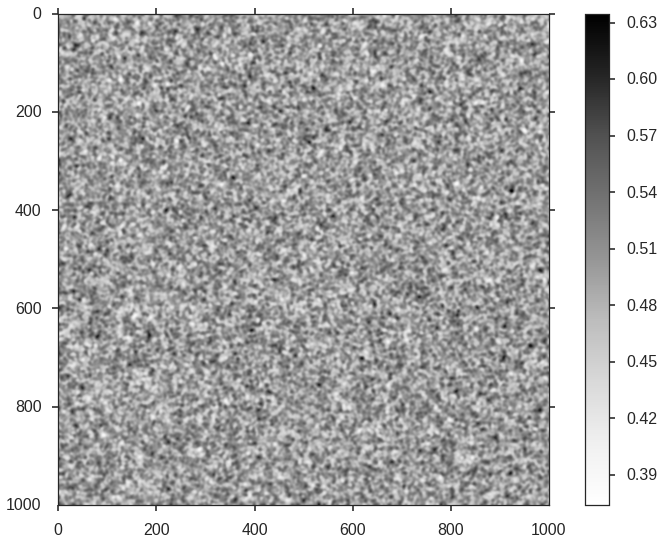

In [49]:
all_noise_2 = nd.gaussian_filter(np.random.random((1000, 1000)), 3)

p.imshow(all_noise_2)
p.colorbar()

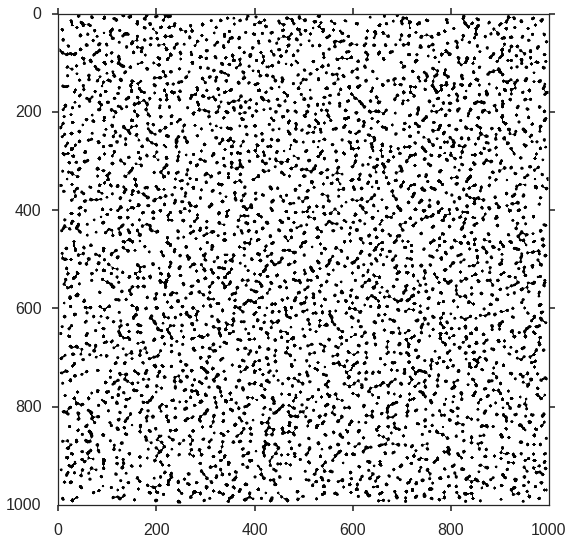

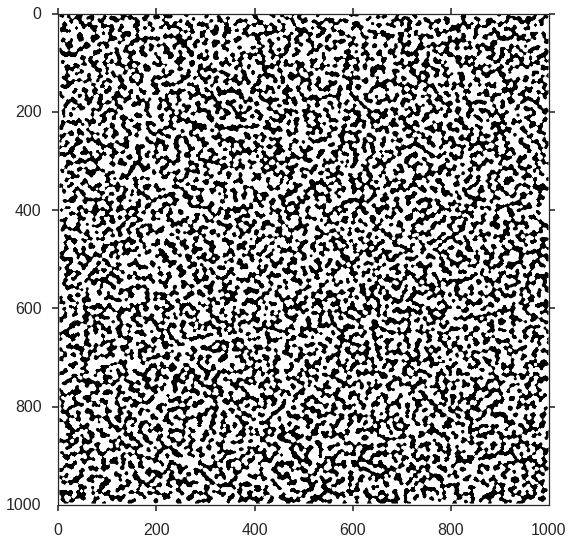

KeyboardInterrupt: 

In [50]:
noise_2_output = []
for i in [5, 10, 20, 30, 50, 100]:
    result = simple_bubble_find(all_noise_2, i, 3).astype(int)
    noise_2_output.append(result)
    p.imshow(result)
    p.show()

In [ ]:
for i in range(6):
    p.imshow(np.logical_and(noise_1_output[i], noise_2_output[i]))
    p.show()

What if small objects are removed before the open/close??

In [ ]:
def simple_bubble_find_2(array, radius, radius_small):
    
    struct = mo.disk(radius)
    struct_small = mo.disk(radius_small)

    # Black tophat
    bth = nd.black_tophat(array, structure=struct)
    
    bth = nd.median_filter(bth, footprint=struct_small)

    # Adaptive threshold
    adapt = \
        threshold_adaptive(bth,
                           radius, method='median',
                           param=radius/2)

    opened_small = nd.binary_opening(adapt, structure=struct_small)
        
    beam_pixels = struct_small.sum()
    cleaned = mo.remove_small_objects(opened_small, min_size=beam_pixels,
                                      connectivity=2)
    # Open/close to clean things up
    opened = nd.binary_opening(cleaned, structure=struct_small)
    closed = nd.binary_closing(opened, structure=struct_small)

    # Remove elements smaller than the original beam.
#     beam_pixels = struct.sum()
    cleaned = mo.remove_small_objects(closed, min_size=beam_pixels,
                                      connectivity=2)
    
    return cleaned

In [ ]:
noise_1_output_2 = []
for i in [6, 10, 20, 30, 50, 100]:
    result = simple_bubble_find_2(all_noise-circle, i, 6).astype(int)
    noise_1_output_2.append(result)
    p.imshow(result)
    p.show()

In [ ]:
noise_2_output_2 = []
for i in [5, 10, 20, 30, 50, 100]:
    result = simple_bubble_find_2(all_noise_2-circle, i, 5).astype(int)
    noise_2_output_2.append(result)
    p.imshow(result)
    p.show()

In [ ]:
for i in range(6):
    p.imshow(np.logical_and(noise_1_output_2[i], noise_2_output_2[i]))
    p.show()

Bottom line, it seems hard to really eliminate the correlated noise features. Should also try removing all objects smaller than the large structure, and possibly all that are more than a couple times larger than the large structure.

Before this, I'm going to see what reconstruction does here:

In [ ]:
seed = np.copy(all_noise)
seed[1:-1, 1:-1] = np.max(seed)

reconst = mo.reconstruction(seed, all_noise, method='erosion')

p.imshow((reconst-all_noise))

In [ ]:
seed_2 = np.copy(all_noise_2)
seed_2[1:-1, 1:-1] = np.max(seed_2)

reconst_2 = mo.reconstruction(seed_2, all_noise_2, method='erosion')

p.imshow((reconst_2-all_noise_2))

In [ ]:
p.imshow((reconst-all_noise)-(reconst_2-all_noise_2))
p.colorbar()

Honestly not much better.

Now try the "remove everything below the large beam" idea:


In [ ]:
def simple_bubble_find_3(array, radius, prev_radius):
    
    struct = mo.disk(radius)
    prev_struct = mo.disk(prev_radius)

    # Black tophat
    bth = nd.black_tophat(array, structure=struct)

    # Adaptive threshold
    adapt = \
        threshold_adaptive(bth,
                           radius, param=radius/2)
        
    open_prev = nd.binary_opening(adapt, structure=prev_struct)
    clos_prev = nd.binary_closing(open_prev, structure=prev_struct)
        
    return clos_prev

In [ ]:
noise_1_output_3 = []
for i, j in zip([10, 20, 30, 50], [8, 10, 20, 30]):
    result = simple_bubble_find_3(all_noise, i, j).astype(int)
    noise_1_output_3.append(result)
    p.imshow(result)
    p.show()

That removed it all. Now add a circle into the noise image and see what that does:

In [ ]:
yy, xx = np.mgrid[-500:500+1, -500:500+1]
circle = np.zeros((1000, 1000))
circle[xx**2+yy**2 <= 30**2] = 1.0

for i, j in zip([10, 20, 30, 50], [8, 10, 20, 30]):
    result = simple_bubble_find_3(all_noise-circle, i, j).astype(int)
    p.imshow(result)
    p.show()

In [ ]:
for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60], [8, 8, 8, 8, 8])):
    if num == 0:
        result = simple_bubble_find_3(test_gauss_holes, i, j).astype(int)
    else:
        result += simple_bubble_find_3(test_gauss_holes, i, j).astype(int)
p.imshow(test_gauss_holes)
p.contour(result, colors='r')
p.show()
    

In [ ]:
for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60], [8, 8, 8, 8, 8])):
    if num == 0:
        result = simple_bubble_find_3(test_noisy_gauss_holes, i, j).astype(int)
    else:
        result += simple_bubble_find_3(test_noisy_gauss_holes, i, j).astype(int)
p.imshow(test_gauss_holes)
p.contour(result, colors='r')
p.show()

In [ ]:
p.imshow(test_noisy_gauss_holes)
p.contour(result, colors='r')
p.show()

This looks fairly solid! Some of the "diffuse" holes will be picked up better at even larger scales (but that's not the goal here).

The key to really cleaning up is defining the minimum size to be at least a couple times the true beam size. I'll need to go back to testing with the real data and see if this has a terrible effect on missing the smallest holes.

One more test: use reconstruction instead of the black tophat, but keep the other operations the same.

In [ ]:
def simple_bubble_find_4(array, radius, prev_radius):
    
    prev_struct = mo.disk(prev_radius)

    seed = nd.maximum_filter(array, radius)
    seed[1:-1, 1:-1] = np.max(seed)
    
    morph_reconst = mo.reconstruction(seed, array, method='erosion') - array
    

    # Adaptive threshold
    adapt = \
        threshold_adaptive(morph_reconst,
                           radius, param=radius/2)
        
    open_prev = nd.binary_opening(adapt, structure=prev_struct)
    clos_prev = nd.binary_closing(open_prev, structure=prev_struct)
        
    return clos_prev

In [ ]:
seed_3 = np.copy(test_gauss_holes)
seed_3[1:-1, 1:-1] = np.max(test_gauss_holes)

reconst_3 = mo.reconstruction(seed_3, test_gauss_holes, method='erosion')

p.imshow((reconst_3-test_noisy_gauss_holes))

In [ ]:

for i in [10, 20, 30, 40, 50, 60]:
    p.imshow(threshold_adaptive(reconst_3-test_gauss_holes, i))
    p.show()

In [ ]:
for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [3]*10)):
    if num == 0:
        result_morph = simple_bubble_find_4(test_gauss_holes, i, j).astype(int)
    else:
        result_morph += simple_bubble_find_4(test_gauss_holes, i, j).astype(int)
p.imshow(test_gauss_holes)
p.contour(result_morph, colors='r')
p.show()

In [ ]:
p.imshow(test_gauss_holes)
p.contour(result, colors='r')
p.contour(result_morph, colors='g')

In [ ]:
for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [8]*10)):
    if num == 0:
        result_morph_noisy = simple_bubble_find_4(test_noisy_gauss_holes, i, j).astype(int)
    else:
        result_morph_noisy += simple_bubble_find_4(test_noisy_gauss_holes, i, j).astype(int)
p.imshow(test_gauss_holes)
p.contour(result_morph_noisy, colors='r')
p.show()

In [ ]:
p.imshow(test_noisy_gauss_holes)
p.contour(result, colors='r')
p.contour(result_morph_noisy, colors='g')

In [ ]:
p.imshow(test_gauss_holes)
p.contour(result_morph, colors='r')
p.contour(result_morph_noisy, colors='g')

In [ ]:
test_smoothed_noisy_gauss = nd.gaussian_filter(test_noisy_gauss_holes, 6)

for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [8]*10)):
    if num == 0:
        result_morph_smooth_noisy = simple_bubble_find_4(test_smoothed_noisy_gauss, i, j).astype(int)
    else:
        result_morph_smooth_noisy += simple_bubble_find_4(test_smoothed_noisy_gauss, i, j).astype(int)
p.imshow(test_smoothed_noisy_gauss)
p.contour(result_morph_smooth_noisy, colors='r')
p.show()

Does this work on real data?

In [ ]:
data_path = "/media/eric/Data_3/VLA/IC1613/"

cube = SpectralCube.read(os.path.join(data_path, "IC1613_NA_ICL001.fits"))

# Remove empty channels
cube = cube[38:65, 500:1500, 500:1500]

In [ ]:
chan_15 = cube[15, :, :].value

In [ ]:
cube.beam.major.value/cube.header['CDELT2']/np.sqrt(8*np.log(2))

In [ ]:
for num, (i, j) in enumerate(zip([10, 20, 30, 40, 50, 60, 70, 80, 90, 100], [8]*10)):
    if num == 0:
        result_chan_15 = simple_bubble_find_4(chan_15, i, j).astype(int)
    else:
        result_chan_15 += simple_bubble_find_4(chan_15, i, j).astype(int)
p.imshow(chan_15, origin='lower')
p.contour(result_chan_15, colors='r')
p.show()

Meh..

Check against function #3:

In [ ]:
for num, (i, j) in enumerate(zip([20, 30, 40, 50, 60, 70, 80], [12]*7)):
    if num == 0:
        result_chan_15_BTH = simple_bubble_find_3(chan_15, i, j).astype(int)
    else:
        result_chan_15_BTH += simple_bubble_find_3(chan_15, i, j).astype(int)
p.imshow(chan_15)
p.contour(result_chan_15_BTH, colors='r')
p.show()

In [ ]:
p.imshow(chan_15, origin='lower')
p.contour(result_chan_15_BTH>0, colors='r')
p.show()

Ya, I think BTH remains the way to go

In [ ]:
for num, (i, j) in enumerate(zip([20, 30, 40, 50, 60, 70, 80], [12]*7)):
    if num == 0:
        result_chan_0_BTH = simple_bubble_find_3(cube[0, :, :].value, i, j).astype(int)
    else:
        result_chan_0_BTH += simple_bubble_find_3(cube[0, :, :].value, i, j).astype(int)
p.imshow(cube[0, :, :].value)
p.contour(result_chan_0_BTH, colors='r')
p.show()